## Leakage Simulation and Detection

### Initialize EPANET Python Toolkit (EPyT)

You should always begin with this command to import the toolkit.

[EPyT](https://github.com/OpenWaterAnalytics/EPyT) is available on [PyPI](https://pypi.org/project/epyt/) and can be installed via `pip install epyt`. To upgrade to the latest version if it's already installed, use `pip install --upgrade epyt`.

In [1]:
%pip install epyt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from epyt import epanet
import tempfile
import requests
import os

<img src="https://github.com/WaterFutures/EPyT-and-EPyT-Flow-Tutorial/blob/main/icons/large_leakage.png?raw=1" alt="Large Leakage" style="display: inline-block; width: 50%; height: 50%;">
<img src="https://github.com/WaterFutures/EPyT-and-EPyT-Flow-Tutorial/blob/main/icons/fire-fighting.png?raw=1" alt="Fire-Fighting" style="display: inline-block; width: 50%; height: 50%;">

### How pressure changes during large leakages and fire-fighting

When flow is increased within the network, e.g., due to fire-fighting, the pressure changes near that location. Investigate this change, at `node '32'.

In [3]:

inpname = ("Walkerton_v1.inp")


In [4]:
G = epanet(inpname)

EPANET version 20200 loaded (EPyT version v1.2.0 - Last Update: 01/08/2024).
Input File Walkerton_v1.inp loaded successfully.



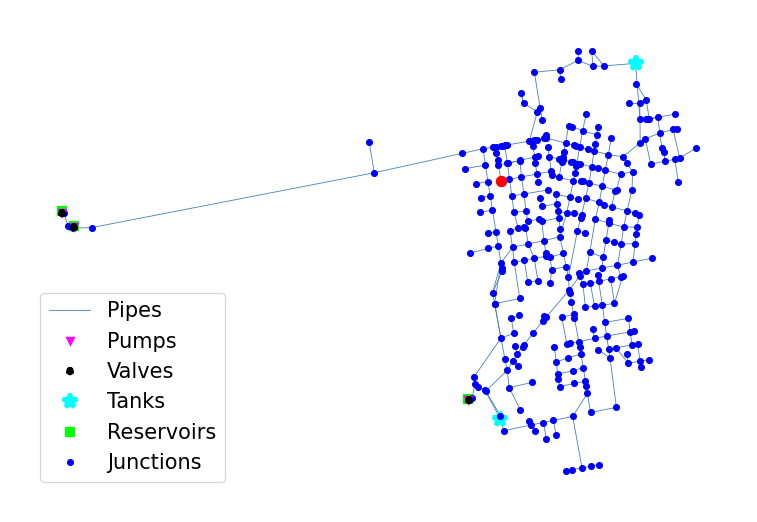

In [5]:
nodeID = 'J155'
G.plot(highlightnode=nodeID)
G.plot_close()

#### During fire-fighting, the base demand may increase up to x5. Will there be sufficient pressure?

In [6]:
idx = G.getNodeIndex(nodeID)
G.printv(idx)

idx = 149


In [7]:
bd = G.getNodeBaseDemands(idx)[1]
G.printv(bd)

bd = [0.94999999]


In [8]:
# Demand multiplicator
demand_multi = 8

In [9]:
import numpy as np
# Create the different demands
d32 = bd * np.arange(1, demand_multi + 1)
G.printv(d32)
help(np.arange)

d32 = [0.94999999 1.89999998 2.84999996 3.79999995 4.74999994 5.69999993
 6.64999992 7.5999999 ]
Help on built-in function arange in module numpy:

arange(...)
    arange([start,] stop[, step,], dtype=None, *, device=None, like=None)

    Return evenly spaced values within a given interval.

    ``arange`` can be called with a varying number of positional arguments:

    * ``arange(stop)``: Values are generated within the half-open interval
      ``[0, stop)`` (in other words, the interval including `start` but
      excluding `stop`).
    * ``arange(start, stop)``: Values are generated within the half-open
      interval ``[start, stop)``.
    * ``arange(start, stop, step)`` Values are generated within the half-open
      interval ``[start, stop)``, with spacing between values given by
      ``step``.

    For integer arguments the function is roughly equivalent to the Python
    built-in :py:class:`range`, but returns an ndarray rather than a ``range``
    instance.

    When using a

In [10]:
# Initialize variable
p32min = np.zeros(len(d32))
for i, demand_value in enumerate(d32):
    G.setNodeBaseDemands(idx, demand_value)
    py_idx = idx - 1
    p32 = G.getComputedHydraulicTimeSeries().Pressure[:, py_idx]
    p32min[i] = np.min(p32)

#### Plot demand vs pressure

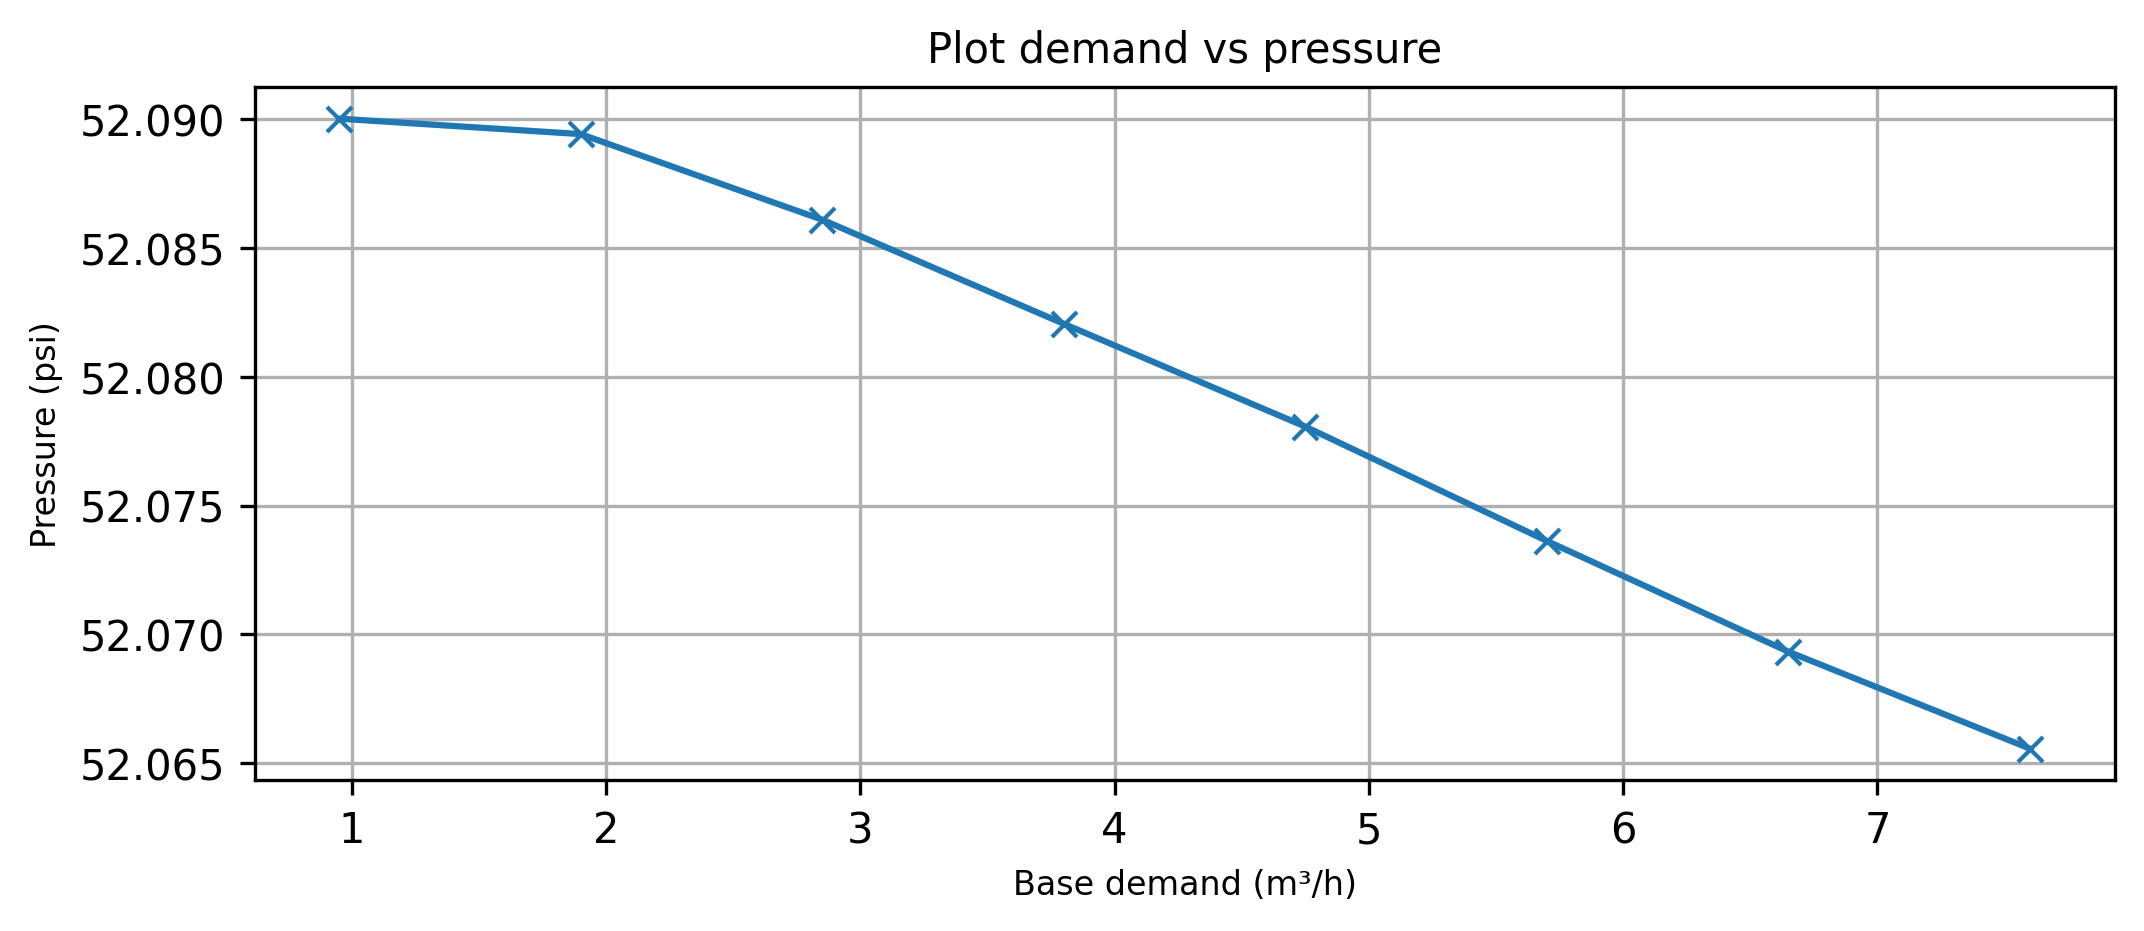

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 3))
fig.set_figwidth(8)
ax.plot(d32, p32min, 'x-')
ax.grid(True)
ax.set_title("Plot demand vs pressure", fontsize=10)
ax.set_xlabel(f"Base demand (m\u00B3/h)", fontsize=8)
ax.set_ylabel("Pressure (psi)", fontsize=8)
plt.show()

##### How about those negative pressures?

### Pressure Driven Simulations

##### When the pressure is low, it should approximate zero. This is not the default mode of operation in EPANET. However, it's easy to set it up:

In [12]:
type = 'PDA'
pmin = 0
preq = 0.1
pexp = 0.5
G.setDemandModel(type, pmin, preq, pexp)

Let's try this again

In [13]:
# Demand multiplicator
demand_multi = 10

In [14]:
# Create the different threads
d32 = bd * np.arange(1, demand_multi + 1)
G.printv(d32)

d32 = [0.94999999 1.89999998 2.84999996 3.79999995 4.74999994 5.69999993
 6.64999992 7.5999999  8.54999989 9.49999988]


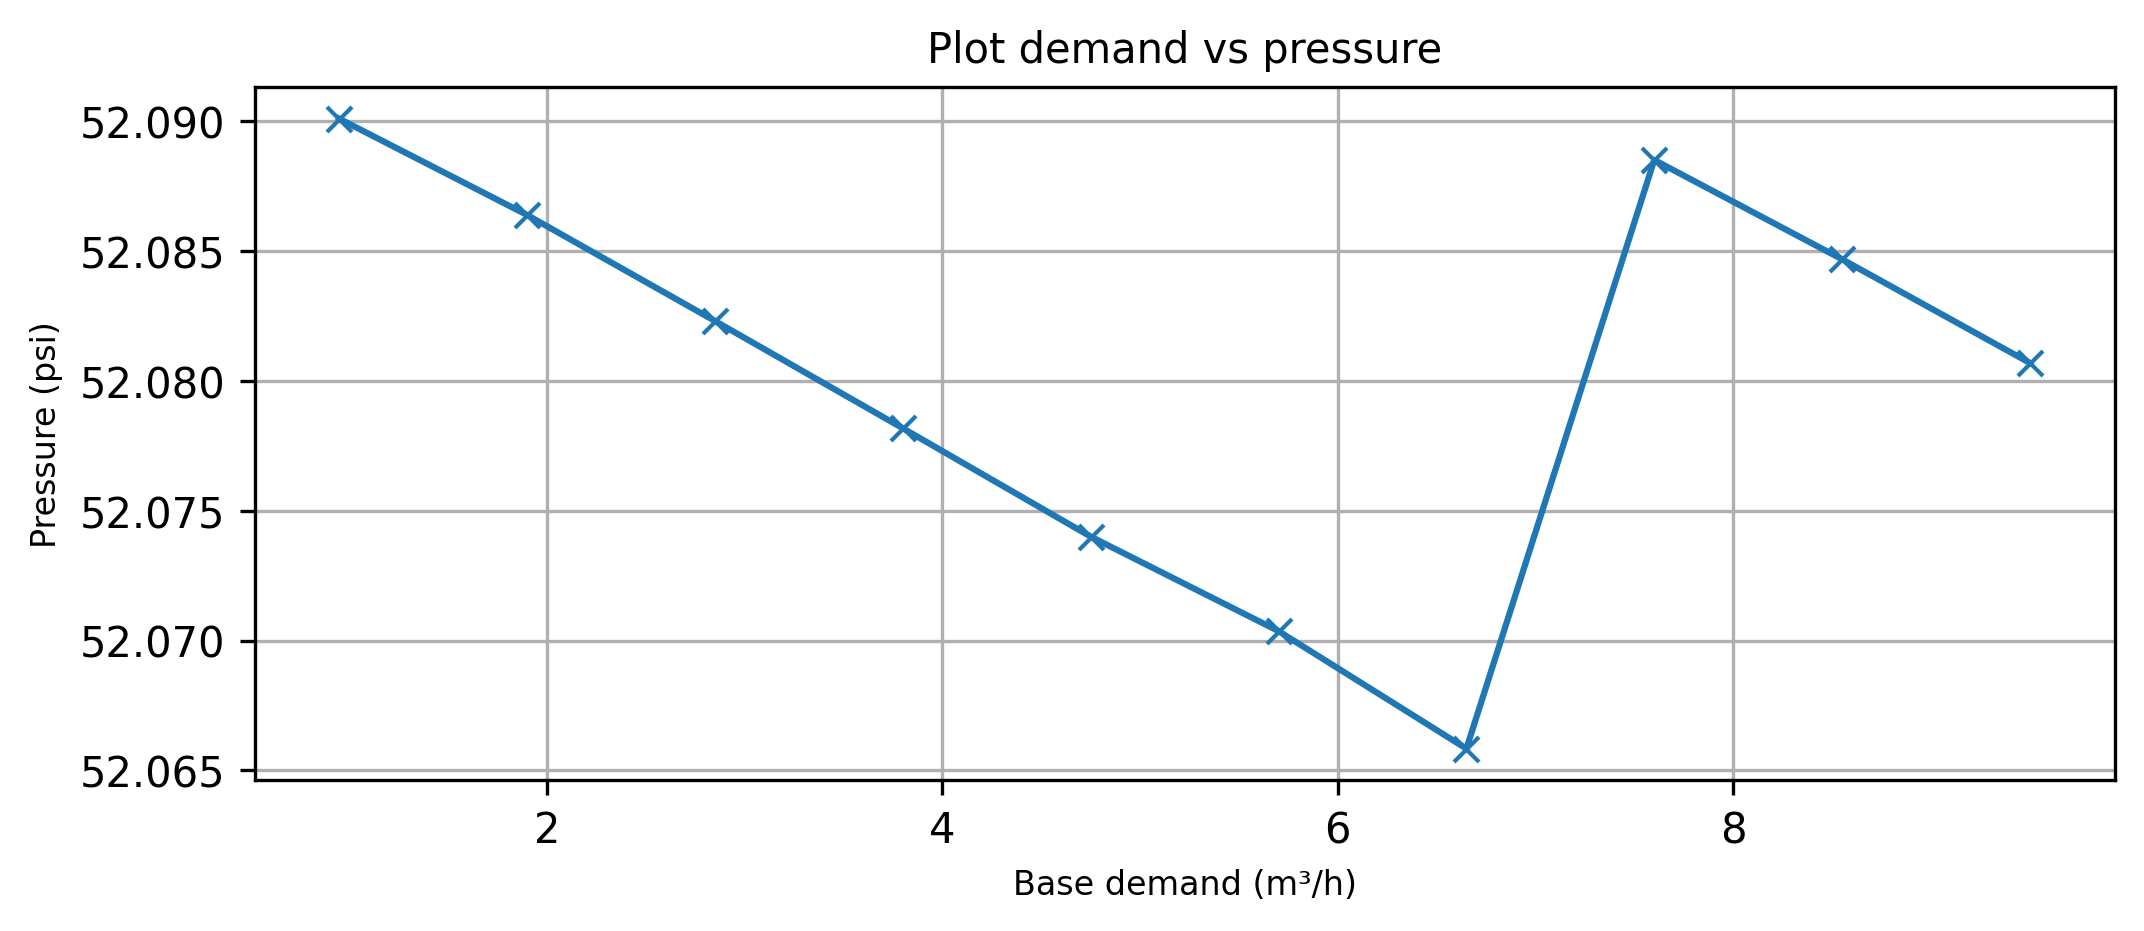

In [15]:
# Initialize variable
p32min = np.zeros(len(d32))

for i, demand_value in enumerate(d32):
    G.setNodeBaseDemands(idx, demand_value)
    p32 = G.getComputedHydraulicTimeSeries().Pressure[:, idx-1]
    p32min[i] = np.min(p32)

# Plot
fig, ax = plt.subplots(figsize=(4, 3))
fig.set_figwidth(8)
ax.plot(d32, p32min, 'x-')
ax.grid(True)
ax.set_title("Plot demand vs pressure", fontsize=10)
ax.set_xlabel(f"Base demand (m\u00B3/h)", fontsize=8)
ax.set_ylabel("Pressure (psi)", fontsize=8)
plt.show()

In [16]:
G.unload()

Could not delete Walkerton_v1_temp.txt: [WinError 32] Proces nie może uzyskać dostępu do pliku, ponieważ jest on używany przez inny proces: 'Walkerton_v1_temp.txt'
Close toolkit for the input file "Walkerton_v1". EPANET Toolkit is unloaded.



### Leakage Simulations
#### Load network amd set simulation duration and hydraulic step

In [17]:
# Download Hanoi_pat input file
inpname = ("Walkerton_v1.inp")

In [18]:
d=epanet(inpname)

d.setTimeSimulationDuration(7*24*60*60)
d.setTimeHydraulicStep(300)

EPANET version 20200 loaded (EPyT version v1.2.0 - Last Update: 01/08/2024).
Input File Walkerton_v1.inp loaded successfully.



#### Simulate without leak

In [19]:
sim_leak_free = d.getComputedHydraulicTimeSeries()
print(d.getAllAttributes(sim_leak_free))

[('Time', array([     0,    300,    305, ..., 604200, 604500, 604800])), ('Pressure', array([[36.01145935, 30.04487991, 29.92488098, ...,  0.        ,
        26.        , 20.        ],
       [36.1914711 , 30.23402405, 30.11402321, ...,  0.        ,
        26.20685577, 20.02790833],
       [36.11643982, 30.18566322, 30.06566238, ...,  0.        ,
        26.21022415, 20.02840042],
       ...,
       [35.51865387, 29.67932892, 29.55932999, ...,  0.        ,
        25.88076401, 18.87868309],
       [35.50976562, 29.67057991, 29.55057907, ...,  0.        ,
        25.87228775, 18.86414719],
       [35.50064087, 29.66144753, 29.54144669, ...,  0.        ,
        25.86314392, 18.84983635]])), ('Demand', array([[ 1.78599998e-01,  1.78599998e-01,  0.00000000e+00, ...,
        -2.60400049e+03,  2.34759863e+03,  9.34421265e+02],
       [ 1.78599998e-01,  1.78599998e-01,  0.00000000e+00, ...,
        -2.60400049e+03,  2.29289233e+03,  9.89133789e+02],
       [ 1.78599998e-01,  1.78599998e-01

##### Get inflow without leak and create measurements by inserting random noise

In [20]:
res_ind = d.getNodeReservoirIndex()
res_link = [np.where(d.NodesConnectingLinksIndex[:, 0] == idx)[0][0] for idx in res_ind]
Inflow1 = sim_leak_free.Flow[:, res_link] # Inflow
eta = np.random.rand(len(Inflow1),1) * np.mean(Inflow1) * 0.0001
y1 = Inflow1 * (1 + eta) # Measured inflow
print(y1)

[[1.30186382e+03 1.07740454e-03 2.71204084e+03]
 [1.29945032e+03 1.06944435e-03 2.70701304e+03]
 [2.62971329e-03 1.09247317e-03 2.71211762e+03]
 ...
 [2.60663008e-03 4.33555757e-03 5.41254508e-03]
 [2.60886270e-03 4.33889959e-03 5.41672241e-03]
 [2.66144644e-03 4.42610112e-03 5.52528415e-03]]


#### Simulate leakage

In [21]:
leak_node_id = 'J155'
leak_node = d.getNodeIndex(leak_node_id)
leak_emit = 20  # Random leak emitter coefficient [2 20]
emit = d.getNodeEmitterCoeff()
emit = np.zeros_like(emit)
emit[leak_node-1] = leak_emit  # Set emitter coefficient (leakage) value
d.setNodeEmitterCoeff(emit)
sim_leak = d.getComputedHydraulicTimeSeries()

##### Get inflow with leak and create measurements by inserting random noise

In [22]:
Inflow2 = sim_leak.Flow[:, res_link]  # inflow
Inflow2[:3*288] = Inflow1[:3*288][:]  # change leak start time
eta = np.random.rand(len(Inflow2),1) * np.mean(Inflow1) * 0.0001
y2 = Inflow2 * (1 + eta)  # measured inflow

##### Plots - Compare inflow in both scenarios

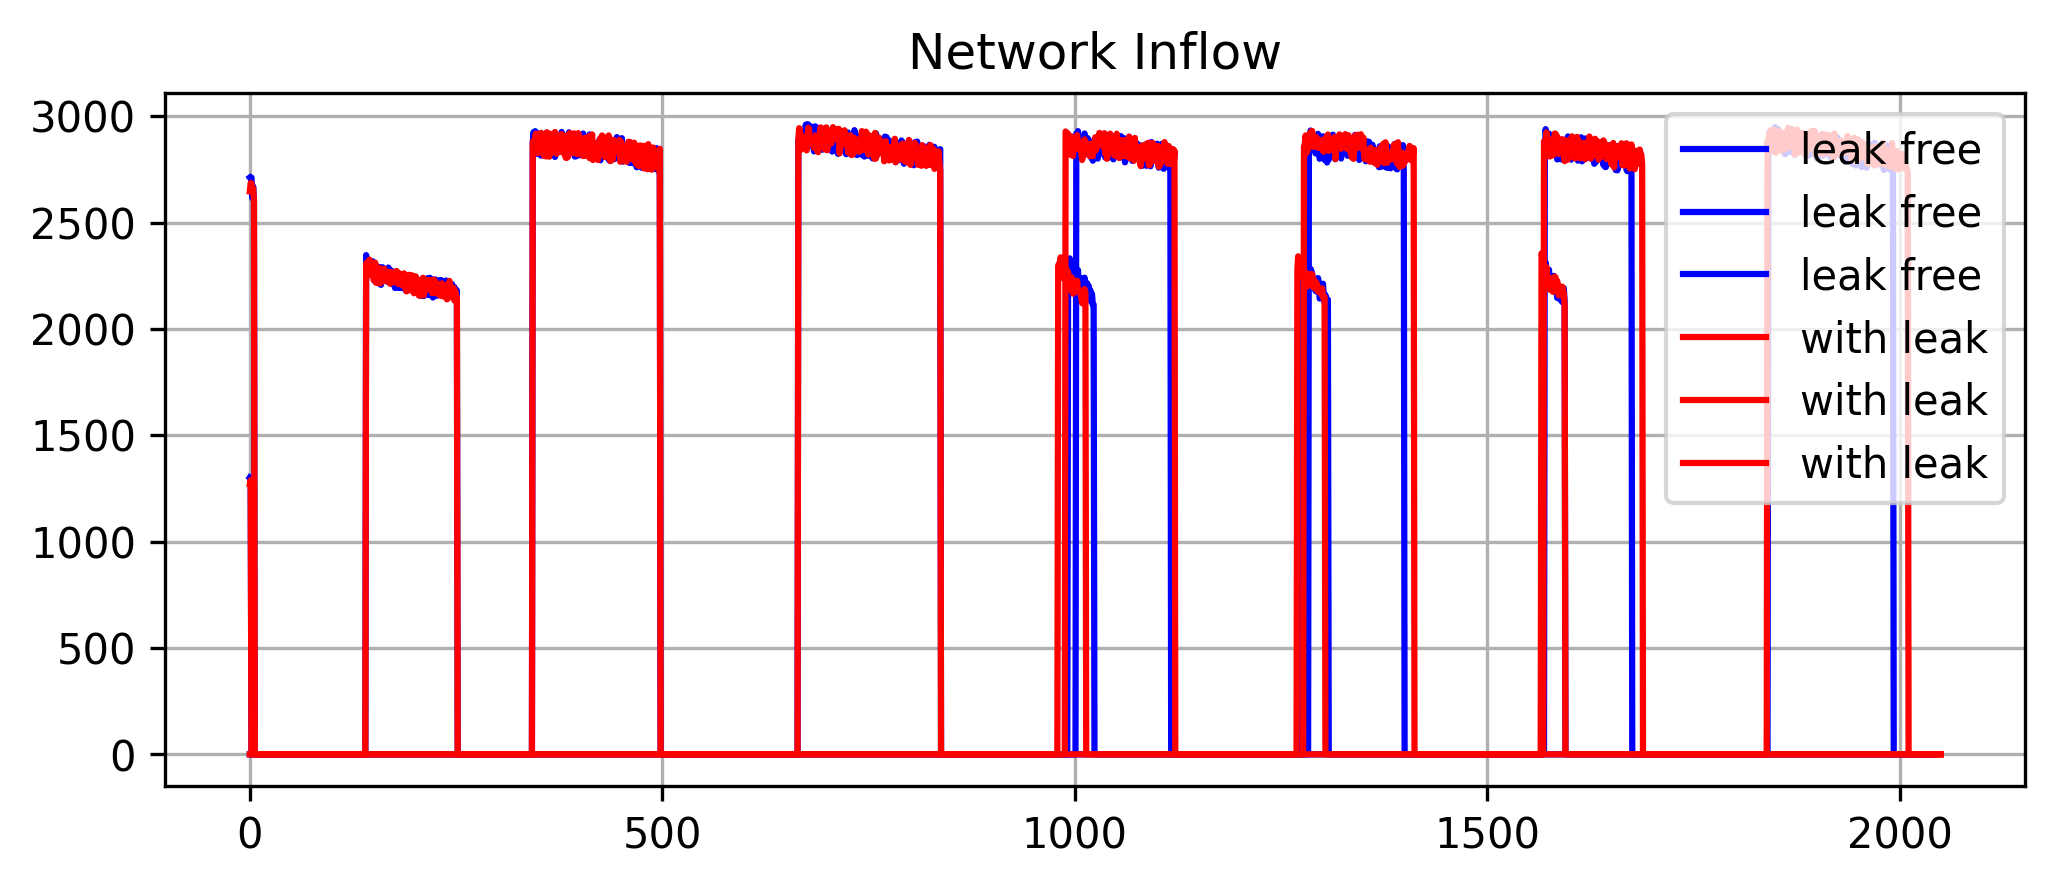

In [23]:
fig, ax = plt.subplots(figsize=(4, 3))
fig.set_figwidth(8)
plt.plot(y1, color='blue', label='leak free')
plt.grid(True)
plt.plot(y2, color='red', label='with leak')
plt.legend(loc='upper right')
plt.title('Network Inflow')
plt.show()

##### Plot leakage location

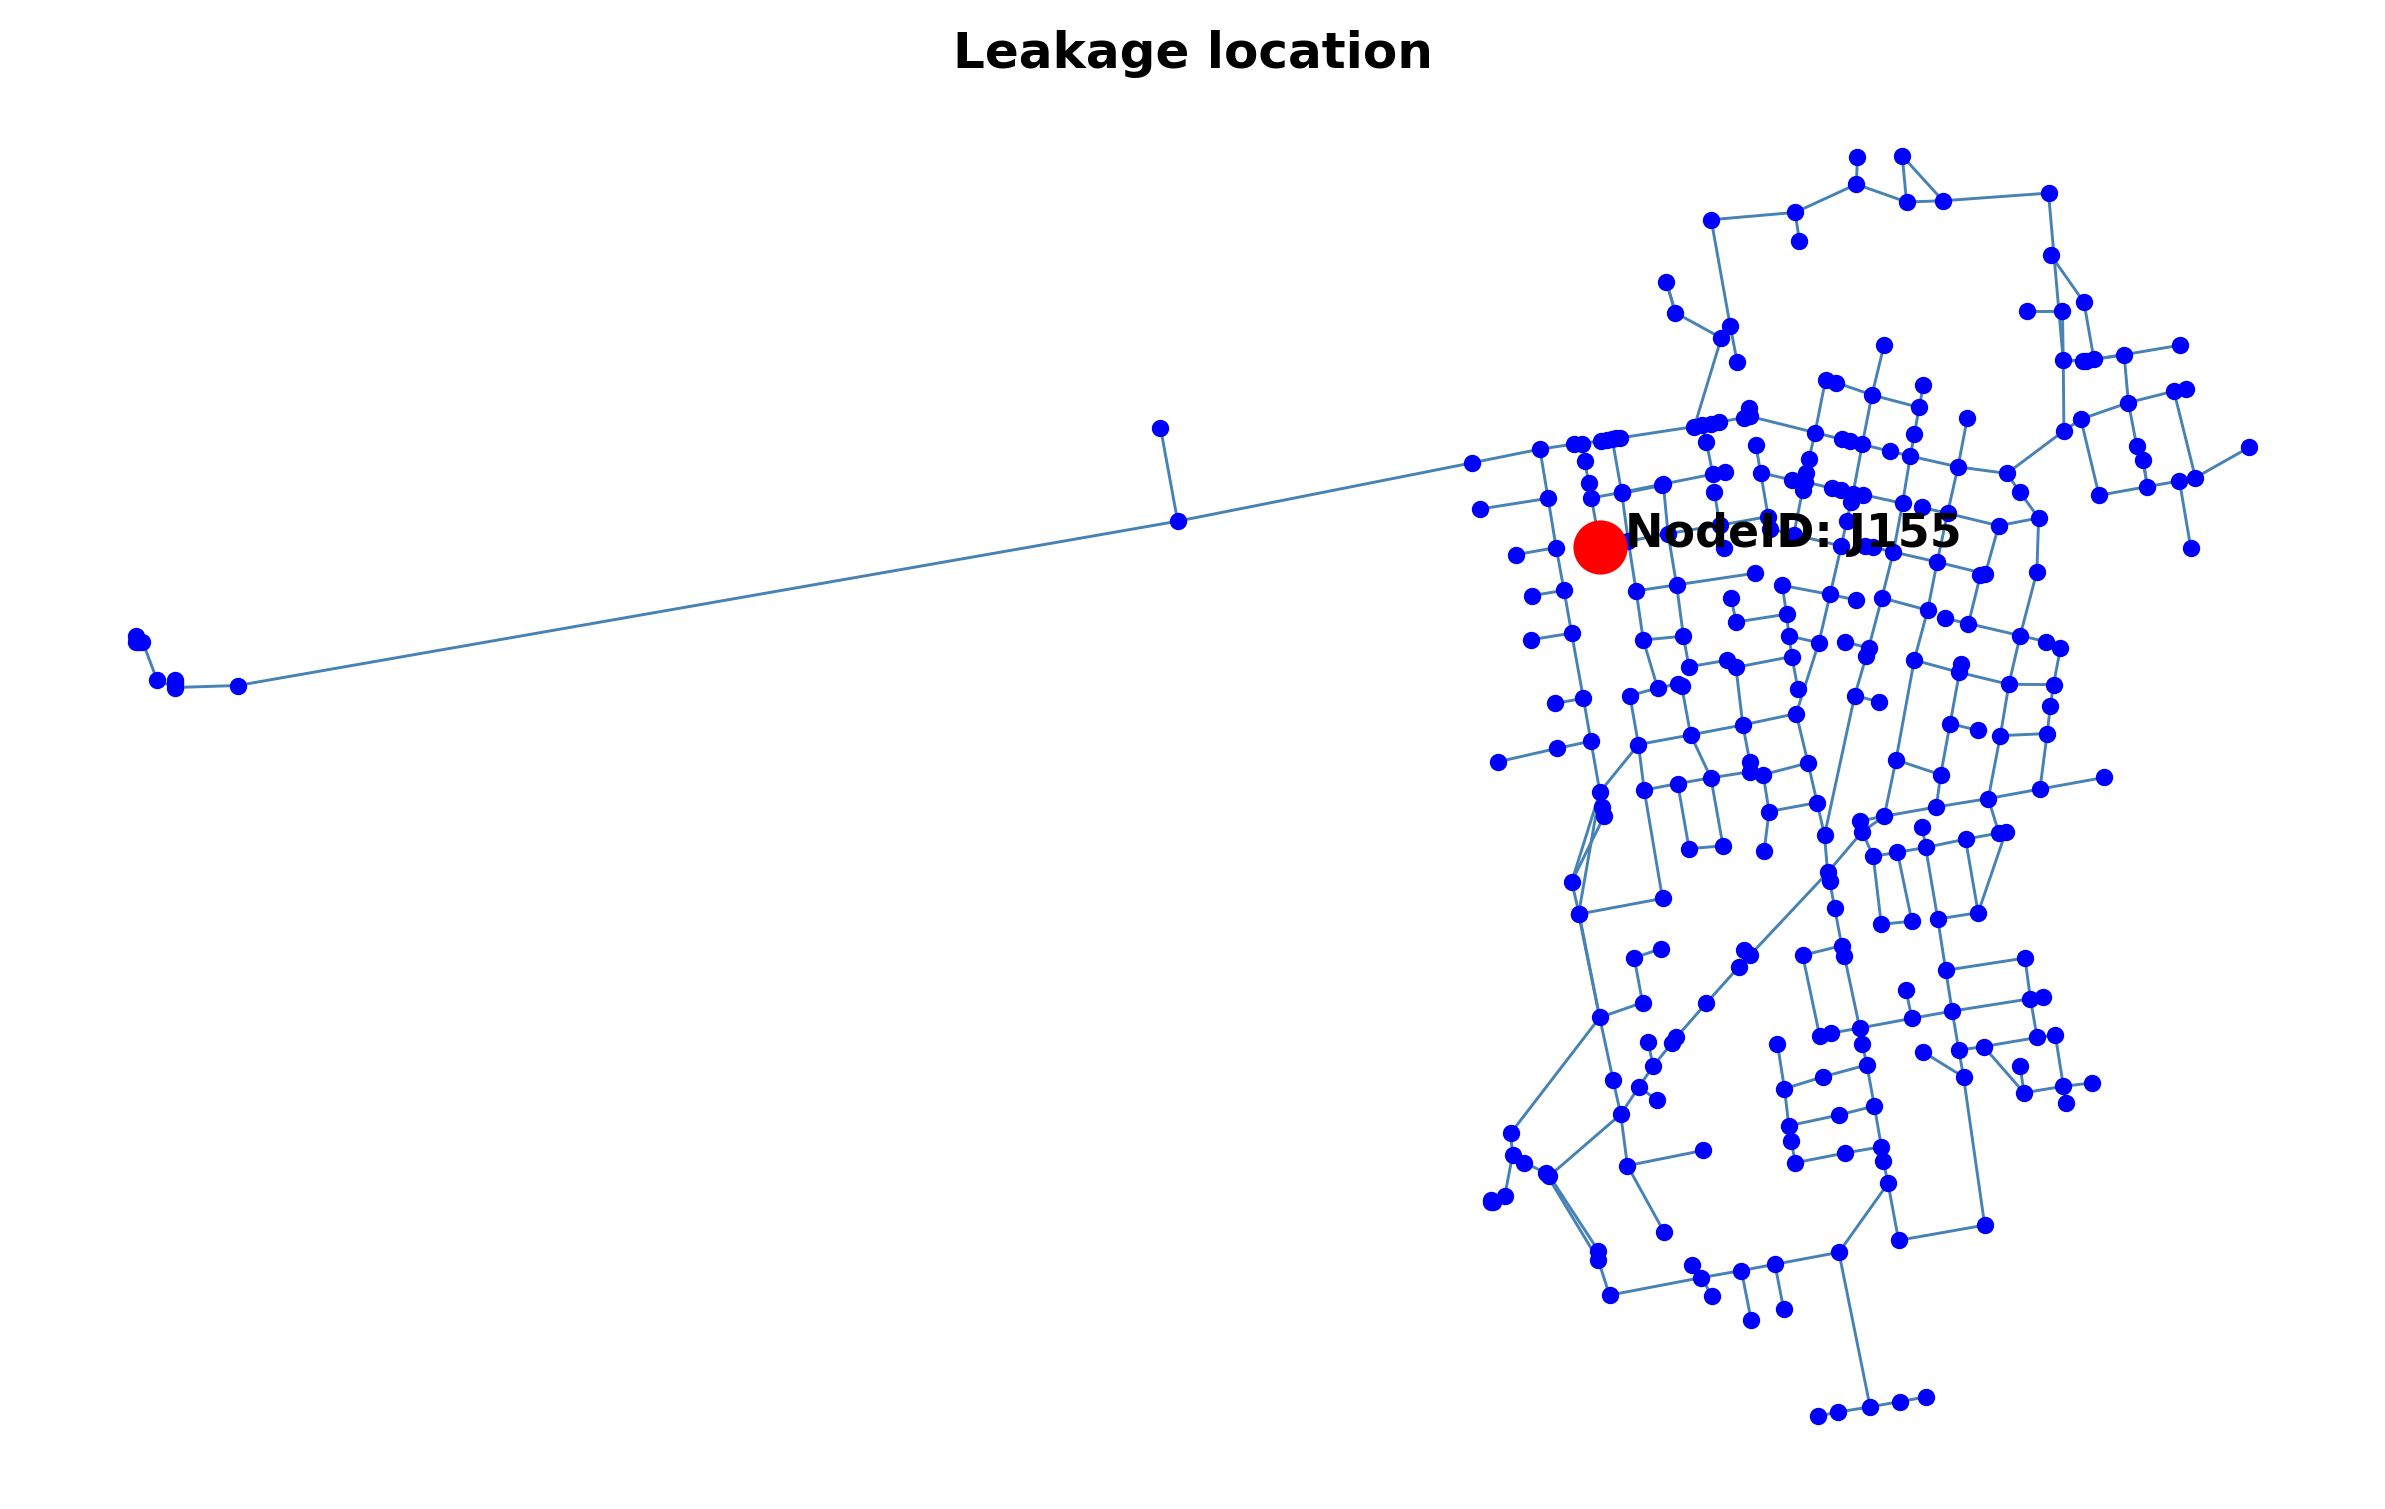

In [24]:
# Custom function to plot the network (alternative to G.plot())
def custom_plot(coor):
    # Note: Does not used vertices
    x_nodes = list(coor['x'].values())
    y_nodes = list(coor['y'].values())
    # Get links connecting nodes
    links = d.getNodesConnectingLinksIndex()
    # Plot the network manually
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    for link in links:
        x_coords = [coor['x'][link[0]], coor['x'][link[1]]]
        y_coords = [coor['y'][link[0]], coor['y'][link[1]]]
        ax.plot(x_coords, y_coords, color='steelblue', linewidth=0.7)
    ax.axis('off')
    # Plot nodes
    ax.scatter(x_nodes, y_nodes, color='blue', s=10, zorder=5)
    return ax

# Get node coordinates
coor = d.getNodeCoordinates()
# Custom plot - network plot
ax = custom_plot(coor)

# Add plot point for the leak node
x_leak = coor['x'][leak_node]
y_leak = coor['y'][leak_node]

# Plot the leak node with a higher zorder
ax.plot(x_leak, y_leak, 'o', color='r', markersize=12, zorder=10)
ax.text(x_leak + 60, y_leak, 'NodeID: ' + leak_node_id, color='black', fontweight='bold', fontsize=11, zorder=10)

# Set the title and show the plot
ax.set_title('Leakage location', fontweight='bold')
plt.show()

### Leakage Detection
#### Minimum Night Flow Analysis

<img src="https://github.com/WaterFutures/EPyT-and-EPyT-Flow-Tutorial/blob/main/icons/leakage_detection.png?raw=1" alt="Leakage Detection" style="width: 60%; height: 60%;">

- Basic idea is that each night the uncertainty is low
- Demand is low
- Pressure is high
- Easier to detect leakages

In [26]:
# Zakładając, że y2 to tablica z danymi, a y2[1:] ma 6150 elementów
y2_trimmed = y2[1:]  # Wycinamy pierwszy element (jeśli to konieczne)

# Oblicz, ile elementów musimy dodać, aby uzyskać 2016 elementów
required_size = 7 * 288
current_size = y2_trimmed.size

# Oblicz, ile elementów trzeba dodać
if current_size < required_size:
    padding_size = required_size - current_size
    # Dodajemy zera na końcu tablicy, aby uzyskać wymagany rozmiar
    y2_padded = np.pad(y2_trimmed, (0, padding_size), mode='constant', constant_values=0)
else:
    y2_padded = y2_trimmed[:required_size]  # Jeśli danych jest więcej, przycinamy

# Przekształcamy w odpowiedni kształt (7, 288)
Y = np.reshape(y2_padded, (7, 864))

# Sprawdzamy wynik
print("Y =", Y.shape)  # Oczekiwany wynik: (7, 288)
d.printv(Y)  # Jeśli chcesz wyświetlić lub użyć tej tablicy w swoim kodzie


Y = (7, 864)
Y = [[1.28934901e+03 1.06113100e-03 2.68597000e+03 ... 2.75256484e-03
  4.49310516e-03 5.57656819e-03]
 [2.68964091e-03 4.38984611e-03 5.44820817e-03 ... 2.71654910e-03
  4.46146713e-03 5.54822864e-03]
 [2.70870879e-03 4.44855810e-03 5.53245451e-03 ... 2.67520188e-03
  4.44004347e-03 5.53694616e-03]
 ...
 [2.58796498e-03 4.29487822e-03 5.35621993e-03 ... 2.59819939e-03
  4.31428952e-03 5.38212022e-03]
 [2.62561464e-03 4.35930073e-03 5.43730832e-03 ... 2.69195458e-03
  4.45455668e-03 5.55006892e-03]
 [2.61854312e-03 4.33152094e-03 5.39714224e-03 ... 2.59249961e-03
  4.32152928e-03 5.39994882e-03]]


In [27]:
MF = np.min(Y, axis=1)
d.printv(MF)

MF = [0.00092762 0.00070666 0.00070242 0.00071763 0.00071873 0.00071187
 0.00070181]


Number of change points: 0


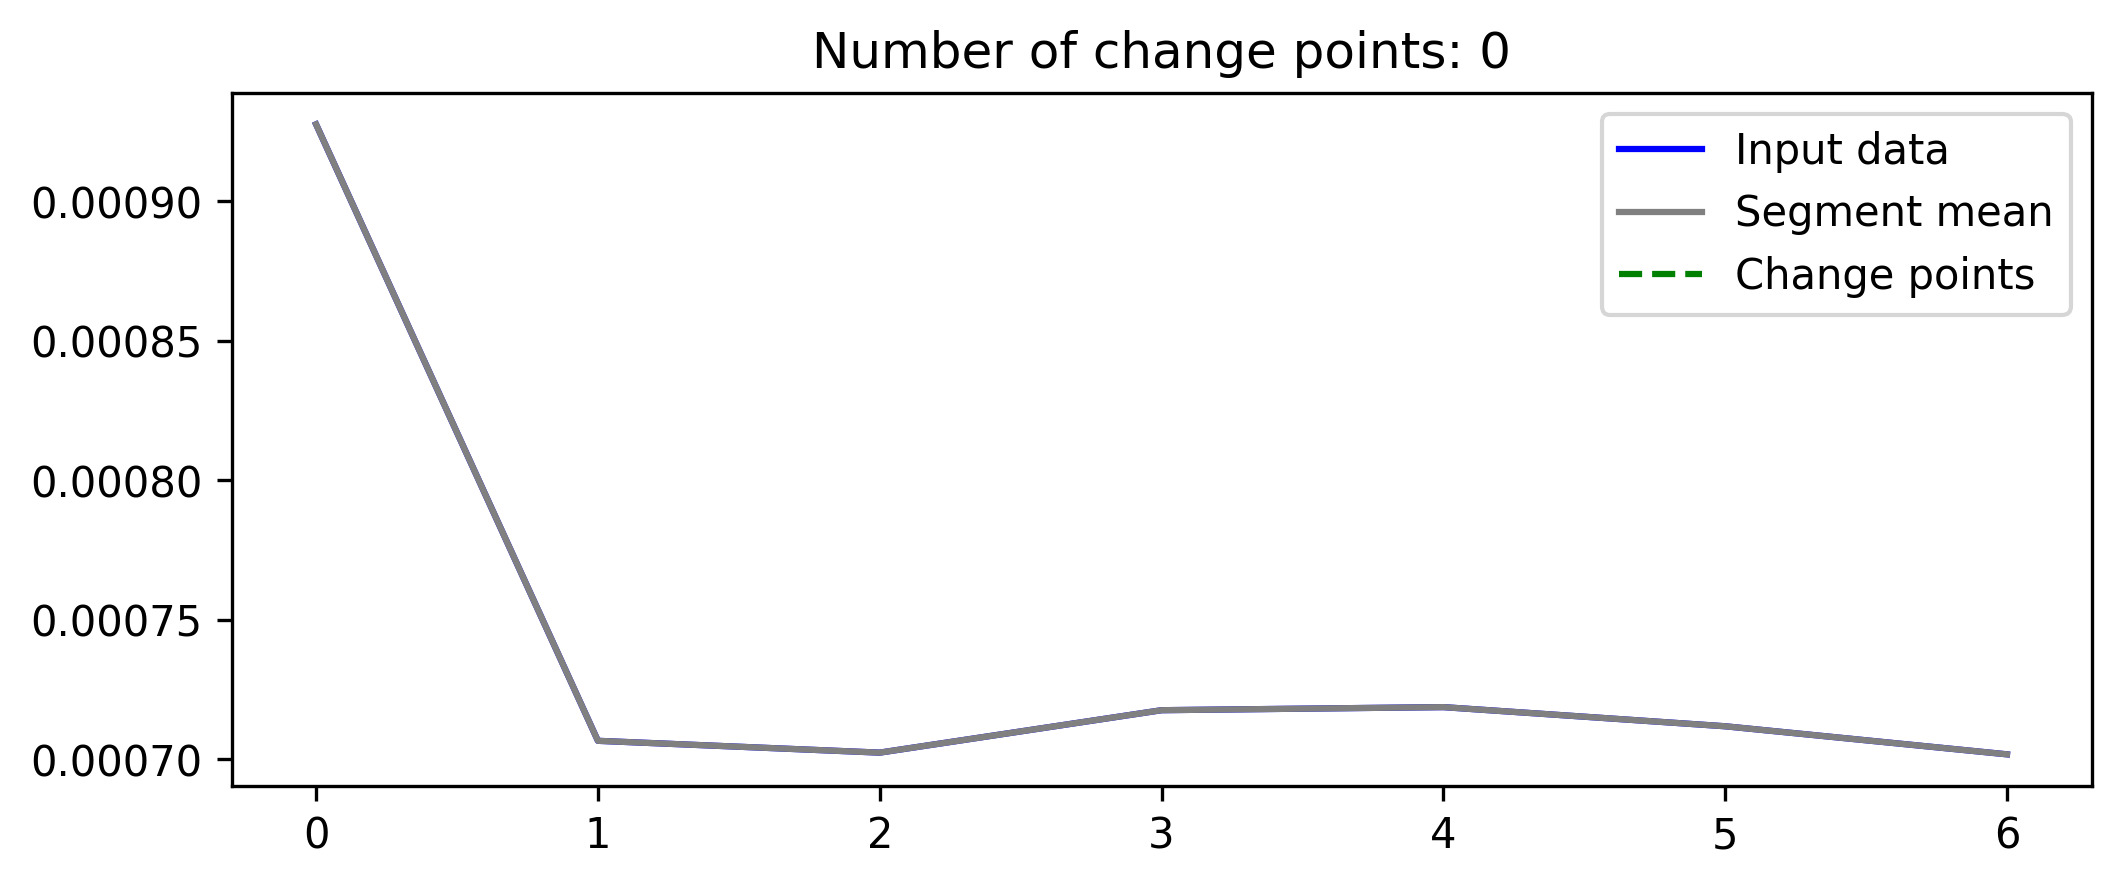

In [28]:
# Calculate change indices based on threshold
threshold = 3
changeIndices = np.abs(np.diff(MF)) > threshold  # Find where the absolute difference between consecutive elements is greater than the threshold
changeIndices = np.insert(changeIndices, 0, False)  # Add False at the beginning to align with MF length

# Create a new figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 3))

# Plot the original data
ax.plot(MF, color='blue', label='Input data')

# Plot the segment mean (in this case, it's the same as the original data)
ax.plot(MF, color='grey', label='Segment mean')

# Find the indices where changes occur
indices = np.where(changeIndices)[0]
x = np.repeat(indices, 3)  # Repeat each index 3 times to align with y3 for plotting vertical lines

# Get the current y-axis limits
ymin, ymax = ax.get_ylim()
ylim_nan_column = np.array([ymin, ymax, np.nan])  # Array to create vertical lines that span the y-axis

# Count the number of change points
nnz_changeIndices = np.count_nonzero(changeIndices)
print("Number of change points:", nnz_changeIndices)

# Create y-coordinates for change points using tile and flatten
y3 = np.tile(ylim_nan_column, (nnz_changeIndices, 1)).flatten()

# Plot the change points as green vertical dashed lines
ax.plot(x, y3, color='green', linestyle='--', label='Change points')

# Set the title to show the number of change points
ax.set_title(f'Number of change points: {np.count_nonzero(changeIndices)}')

# Add a legend in the upper right corner
ax.legend(loc='upper right')

# Display the plot
plt.show()

#### Detecting changes
- Change detection algorithms
- Limit checking, change in mean
- Cumulative Sum (CUSUM)

##### Limit checking, the most simple detection algorithm

In [29]:
threshold = 30
d.printv(threshold)

threshold = 30


In [30]:
alert = MF-MF[0] > threshold
if np.any(alert):
    # Find the first occurrence of True
    first_true_index = np.argmax(alert)

    # Set all elements from the first True to the end to True
    alert[first_true_index:] = True
d.printv(alert)

alert = [False False False False False False False]


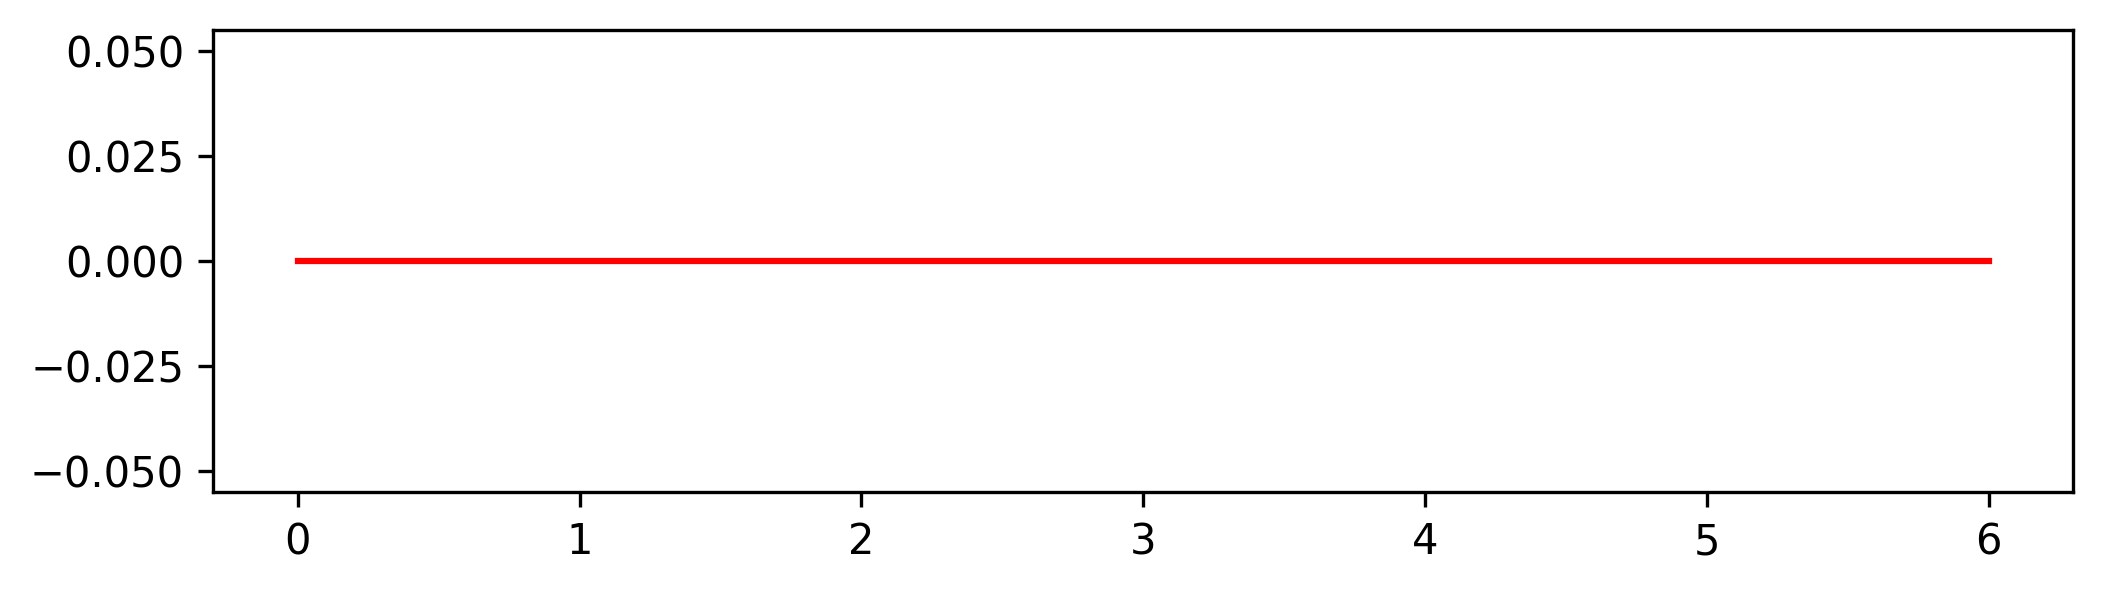

In [31]:
fig = plt.figure()
plt.plot(alert, 'r-')
fig.set_figwidth(8)
plt.show()

##### A different approach would be to take a window of minimum (night) flows, and compare them with the new minimum flow. If it exceeds a precalculated distance, the issue an alert.